## Imports and Data Loading

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
np.random.seed(8055)

In [2]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60


gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
display(final_gcs)

#display(hr)
#display(resp)
#display(sao2)

,patientunitstayid,observationoffset,Key,Value,origin
0,172448,2.500000,Motor,1.0,nurse_charting
31,242714,46.850000,Motor,6.0,nurse_charting
40,242825,12.733333,Motor,6.0,nurse_charting
45,243176,54.566667,Motor,6.0,nurse_charting
86,243493,59.033333,Motor,6.0,nurse_charting
...,...,...,...,...,...
135846,3351268,187.383333,Motor,6.0,nurse_charting
135847,3351533,29.583333,Motor,6.0,nurse_charting
135858,3351909,156.950000,Motor,6.0,nurse_charting
135900,3352618,346.600000,Motor,6.0,nurse_charting


# Lab Data

In [4]:
# Loading lab data
lab = pd.read_csv('data/lab_data.csv')
lab = lab[lab['labresultoffset'] > -1]
lab = lab[lab['labresultoffset'] <= 24*60]
# display(lab)
labtypes = list(lab['labname'].drop_duplicates())

In [5]:
# Getting table of averages over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_avgs = labtypedata.groupby('patientunitstayid').mean()['labresult']
labtypedata_avgs = labtypedata_avgs.to_frame()
labtypedata_avgs = labtypedata_avgs.reset_index()
labtypedata_avgs =labtypedata_avgs.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_avgs1 = labtypedata.groupby('patientunitstayid').mean()['labresult']
    labtypedata_avgs1 = labtypedata_avgs1.to_frame()
    labtypedata_avgs1 = labtypedata_avgs1.reset_index()
    labtypedata_avgs1 =labtypedata_avgs1.rename(columns = {'labresult':l})
    labtypedata_avgs = labtypedata_avgs.merge(labtypedata_avgs1, how='outer', on='patientunitstayid')

In [6]:
labtypedata_avgs = labtypedata_avgs[labtypedata_avgs.columns[labtypedata_avgs.isnull().mean() < 0.2]]
labtypedata_avgs.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,143094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,143103,34.2,12.10,85.9,3.980,258.0,19.5,35.4,13.50,100.5,133.5,153.5,7.55,20.0,0.840,7.0,3.833333
2,144116,41.7,13.50,85.3,4.890,227.0,9.5,32.4,15.60,105.0,145.0,119.0,9.60,31.0,1.360,26.0,3.600000
3,145396,32.7,11.30,84.7,3.860,319.0,12.4,34.6,11.90,102.0,135.5,137.0,7.85,24.5,0.580,8.0,3.566667
4,145840,42.1,14.65,95.8,4.395,165.5,11.6,34.8,14.85,99.0,133.0,186.0,9.20,26.0,1.675,27.5,3.550000


In [7]:
lab_avgs_map = {}
for l in labtypes:
    if l in labtypedata_avgs.columns:
        col = list(labtypedata_avgs[l].dropna())
        if len(col) != 0:
            avg = sum(col)/len(col)
            lab_avgs_map[l] = avg
        else:
            labtypedata_avgs = labtypedata_avgs.drop(columns=l)
# print(lab_avgs_map)

In [8]:
# Filling in na values for labtypedata_avgs.columns with averages
# for that column
for l in labtypedata_avgs.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs[l]
        labtypedata_avgs[l] = col.fillna(lab_avgs_map[l])
labtypedata_avgs.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,143094,34.79829,11.66444,90.809447,3.851774,200.467877,11.040745,33.477334,14.317295,105.805683,139.268547,130.601209,8.382605,24.226154,1.015563,17.415488,3.961266
1,143103,34.20000,12.10000,85.900000,3.980000,258.000000,19.500000,35.400000,13.500000,100.500000,133.500000,153.500000,7.550000,20.000000,0.840000,7.000000,3.833333
2,144116,41.70000,13.50000,85.300000,4.890000,227.000000,9.500000,32.400000,15.600000,105.000000,145.000000,119.000000,9.600000,31.000000,1.360000,26.000000,3.600000
3,145396,32.70000,11.30000,84.700000,3.860000,319.000000,12.400000,34.600000,11.900000,102.000000,135.500000,137.000000,7.850000,24.500000,0.580000,8.000000,3.566667
4,145840,42.10000,14.65000,95.800000,4.395000,165.500000,11.600000,34.800000,14.850000,99.000000,133.000000,186.000000,9.200000,26.000000,1.675000,27.500000,3.550000


In [9]:
# Getting table of measurement counts over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_cts = labtypedata.groupby('patientunitstayid').count()['labresult']
labtypedata_cts = labtypedata_cts.to_frame()
labtypedata_cts = labtypedata_cts.reset_index()
labtypedata_cts =labtypedata_cts.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_cts1 = labtypedata.groupby('patientunitstayid').count()['labresult']
    labtypedata_cts1 = labtypedata_cts1.to_frame()
    labtypedata_cts1 = labtypedata_cts1.reset_index()
    labtypedata_cts1 =labtypedata_cts1.rename(columns = {'labresult':l})
    labtypedata_cts = labtypedata_cts.merge(labtypedata_cts1, how='outer', on='patientunitstayid')

In [10]:
labtypedata_cts = labtypedata_cts[labtypedata_cts.columns[labtypedata_cts.isnull().mean() < 0.2]]
labtypedata_cts = labtypedata_cts.apply(lambda x: x.fillna(x.median()),axis=0)

In [11]:
#print(labtypedata_cts.median())
#labtypedata_cts = labtypedata_cts > labtypedata_cts.median()
labtypedata_cts.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,143094,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,143103,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,8.0,24.0,8.0,8.0,8.0,8.0,8.0,12.0
2,144116,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,145396,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,12.0
4,145840,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


# Demographic Data

In [11]:
# Loading demographic data
demographic_all = pd.read_csv('data/patient_demographics_data.csv')

demographic_all.head()

died = demographic_all.loc[:, ['patientunitstayid', 'unitdischargestatus']]
died['alive'] = died['unitdischargestatus'] == 'Alive'
died = died.drop_duplicates()
display(died)

,patientunitstayid,unitdischargestatus,alive
0,2896749,Alive,True
1,976143,Alive,True
2,1823818,Alive,True
3,2715079,Alive,True
4,1015921,Alive,True
...,...,...,...
9405,2263791,Alive,True
9406,174499,Alive,True
9407,1480007,Alive,True
9408,962326,Alive,True


In [12]:
for col in demographic_all.columns:
    print(col)

# Keeping the following columns (numerical for now):
# to_keep=['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight']
to_keep=['age', 'admissionheight', 'admissionweight', 'patientunitstayid']
demographic = demographic_all[to_keep]
demographic.head()
print(demographic.dtypes)

Unnamed: 0
patientunitstayid
diagnosisstring
patientunitstayid.1
patienthealthsystemstayid
gender
age
ethnicity
hospitalid
wardid
apacheadmissiondx
admissionheight
hospitaladmittime24
hospitaladmitoffset
hospitaladmitsource
hospitaldischargeyear
hospitaldischargetime24
hospitaldischargeoffset
hospitaldischargelocation
hospitaldischargestatus
unittype
unitadmittime24
unitadmitsource
unitvisitnumber
unitstaytype
admissionweight
dischargeweight
unitdischargetime24
unitdischargeoffset
unitdischargelocation
unitdischargestatus
uniquepid
age                   object
admissionheight      float64
admissionweight      float64
patientunitstayid      int64
dtype: object


In [13]:
demographic = demographic.replace('> 89', 90)
demographic.head()

,age,admissionheight,admissionweight,patientunitstayid
0,29,172.7,70.00,2896749
1,35,157.5,77.10,976143
2,85,182.8,84.40,1823818
3,72,177.8,71.66,2715079
4,90,162.5,60.90,1015921


In [14]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

display(hr.loc[hr['patientunitstayid'] == 143274])

,patientunitstayid,offset,value
12,143274,1.016667,95.0
13,143274,1.100000,97.0
14,143274,1.183333,97.0
15,143274,1.266667,98.0
16,143274,1.350000,98.0
...,...,...,...
566,143274,47.183333,103.0
567,143274,47.266667,112.0
568,143274,47.350000,109.0
569,143274,47.433333,142.0


## Set Parameters

In [15]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.25

## Bin data

In [16]:
# split data into bins based on summarization_int
bins=np.arange(25, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_grouped['offset'] = gcs_grouped['observationoffset']
gcs_grouped['value'] = gcs_grouped['Value']
gcs_grouped = gcs_grouped.drop(['observationoffset', 'Value'], axis = 1)
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

C:\Users\12489\Anaconda3\envs\PCM\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Motor GCS')

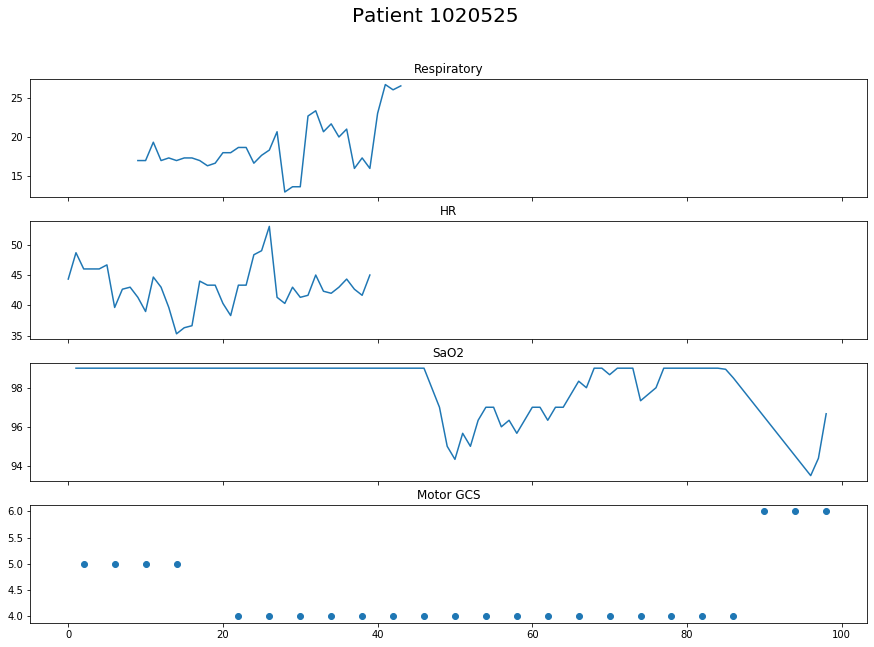

In [17]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

## Prepare Datasets

In [18]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [19]:
# get first 24 hrs
hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < 96].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(x.median()))

#display(resp_first24)
#display(sao2_first24)

C:\Users\12489\Anaconda3\envs\PCM\lib\site-packages\numpy\lib\nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [20]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
print(further_exclusion.shape)

(154,)


In [21]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
print(X_gcs)

[[1. 1. 1. ... 1. 1. 1.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 ...
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]]


# Modeling

In [22]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'over'

# select model family
model_family = 'logistic'

In [23]:
id_df = pd.DataFrame(keys, columns =['patientunitstayid'])
# id_df.head()
labtypedata_cts_allids = labtypedata_cts.merge(id_df, how='right', on='patientunitstayid')
labtypedata_cts_allids = labtypedata_cts_allids.fillna(0)
print(labtypedata_cts_allids.shape)
labtypedata_cts_allids.head()

(2248, 17)


,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,172448,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,12.0
1,242714,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,242825,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,244161,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,245210,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [24]:
labtypedata_avgs_allids = labtypedata_avgs.merge(id_df, how='right', on='patientunitstayid')
print(labtypedata_avgs_allids.shape)
for l in labtypedata_avgs_allids.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs_allids[l]
        labtypedata_avgs_allids[l] = col.fillna(lab_avgs_map[l])
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
labtypedata_avgs_allids.head()

(2248, 17)


,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,172448,31.900000,11.150000,86.000000,3.71,90.000000,12.2,35.1,18.8,110.75,146.75,129.0,8.95,30.75,1.5725,24.5,3.50
1,242714,36.100000,12.000000,96.800000,3.73,205.000000,10.8,33.2,12.6,97.00,136.00,131.0,8.80,28.00,0.6000,14.0,4.50
2,242825,29.700000,9.600000,90.000000,3.31,142.000000,8.7,32.2,13.5,101.00,138.00,141.0,8.20,27.00,0.8000,24.0,4.70
3,244161,23.533333,8.233333,89.033333,2.64,193.333333,29.2,35.0,12.4,100.50,138.00,135.5,8.25,24.50,1.9000,40.5,4.85
4,245210,29.800000,9.150000,81.800000,3.73,325.000000,10.9,30.5,16.6,104.00,138.50,128.0,8.80,22.00,1.6000,22.5,3.75


In [25]:
dem_allids = demographic.merge(id_df, how='right', on='patientunitstayid')
dem_allids = dem_allids.drop_duplicates()
print(dem_allids.shape)
dem_allids = dem_allids.fillna(dem_allids.mean())
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
dem_allids.head()

death = died.merge(id_df, how = 'right', on = 'patientunitstayid')
deathstatus = death['alive'].values[:, np.newaxis]

(2248, 4)


In [26]:
labavg_cols = []
for c in labtypedata_avgs_allids.columns:
    if c != 'patientunitstayid':
        labavg_cols.append(c)
X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
        None] for g in keys])[0]

labcts_cols = []
for c in labtypedata_cts_allids.columns:
    if c != 'patientunitstayid':
        labcts_cols.append(c)
X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
        None] for g in keys])[0]

dem_cols = []
for c in dem_allids.columns:
    if c != 'patientunitstayid':
        dem_cols.append(c)
X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

In [38]:
mort = False
scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   
else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)

X_naive = np.hstack([X_phys, X_labdem])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

print(X_naive.shape)
# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
    

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

(2248, 60)


In [39]:
# modify labels
if mort:
    testY_mod = testY.copy()
    testY_mod[testY == False] = 0
    testY_mod[testY == True] = 1

    trainY_mod = trainY.copy()
    trainY_mod[trainY ==False] = 0
    trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 0
    testY_mod[testY == 6] = 1

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 0
    trainY_mod[trainY == 6] = 1

# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=1000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

(2464, 60)
Train Score: 0.8628246753246753


C:\Users\12489\Anaconda3\envs\PCM\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test Score: 0.8933333333333333
AUC: 0.9078146997104684
Sensitivity: 0.9044943820224719
Specificity: 0.8085106382978724
Precision: 0.8723051409618574
Recall: 0.9850187265917603


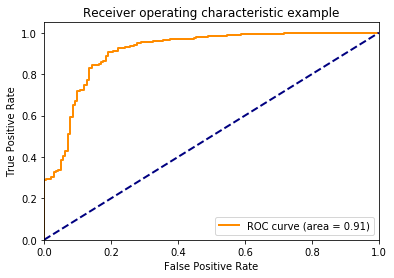

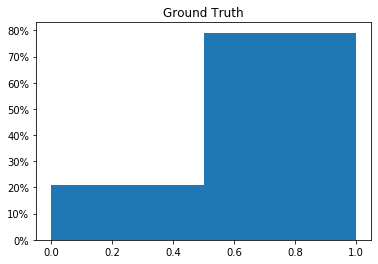

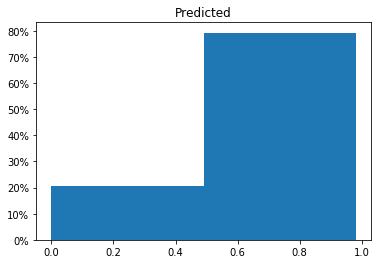

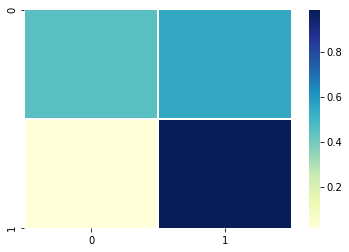

In [40]:
# test model
predY = clf.predict_proba(testX)[:, 1]
print("Test Score:", clf.score(testX, testY_mod))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", auc)

# plot roc curve
fpr, tpr, _ = roc_curve(testY_mod, predY)
precision, recall, thresholds = precision_recall_curve(testY_mod, predY)
bestThreshInd = np.argmax(np.square(tpr) + np.square(1 - fpr))
print("Sensitivity: " + str(tpr[bestThreshInd]))
print("Specificity: " + str(1 - fpr[bestThreshInd]))
print("Precision: " + str(precision[bestThreshInd]))
print("Recall: " + str(recall[bestThreshInd]))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
confusion = confusion_matrix(testY_mod, predY > thresholds[bestThreshInd])
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")